<a href="https://colab.research.google.com/github/Abdelrahman26/FarmTopia-CV-Internship/blob/main/FarmTopia-CV-Internship/Anwar/ccmm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2.jpeg: (1040, 780, 3), 108 keypoints, 64 descriptors
1.jpeg: (1040, 780, 3), 39 keypoints, 64 descriptors


/usr/local/lib/python3.7/dist-packages/cliquematch/wrappers/a2agraph.py:38: UserWarning: A2AGraph: Using default distance metric (Euclidean) for both arrays
  warn("A2AGraph: Using default distance metric (Euclidean) for both arrays")


[[252.36618042 287.27624512]
 [278.13095093 283.5473938 ]
 [216.91896057 364.58303833]
 [ 38.72696304 392.63537598]
 [126.94579315 164.51828003]
 [319.61877441 193.48512268]
 [177.91773987 265.01635742]
 [249.11056519 209.02194214]
 [ 32.6441803  298.31921387]
 [257.22122192 292.99435425]
 [258.95767212 294.70559692]
 [256.52545166 280.96005249]
 [207.09809875 354.74841309]
 [257.98950195  98.96766663]
 [257.84469604 298.75714111]]
[[590.98968506 204.43867493]
 [616.97991943 200.70280457]
 [553.5960083  282.07611084]
 [372.28695679 311.12988281]
 [464.83929443  81.05992889]
 [628.92858887 108.78925323]
 [515.20458984 182.70396423]
 [589.54193115 126.45858002]
 [379.66430664 225.9561615 ]
 [623.13861084 205.57839966]
 [611.82580566 207.20458984]
 [595.75579834 210.31221008]
 [543.83728027 272.40466309]
 [601.80529785  16.44417763]
 [597.19226074 211.9977417 ]]


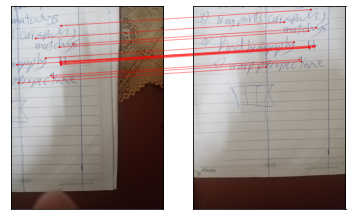

32.64418029785156   319.6187744140625
[[ 1.12218712e+00 -3.75830184e-02  3.39597112e+02]
 [ 3.01052817e-02  1.00575381e+00 -8.64440760e+01]
 [ 2.39341493e-04 -9.55044922e-05  1.00000000e+00]]
Result image


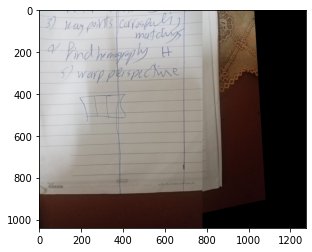

In [34]:
"""
    Example application of cliquematch, an implementation of the
    CCMM algorithm described in:
    San Segundo, Pablo, and Jorge Artieda. "A novel clique formulation for the
    visual feature matching problem." Applied Intelligence 43.2 (2015):
"""
import cv2
import numpy as np
import cliquematch
from matplotlib import pyplot as plt
from matplotlib.patches import Circle, ConnectionPatch


class ImageData(object):
    surf = cv2.xfeatures2d.SURF_create(2000)

    def __init__(self, path, flags=0):
        self._path = path
        self.data = cv2.imread(path)
        kps, desc = self.surf.detectAndCompute(self.data, None)
        self.pts = np.float64(cv2.KeyPoint.convert(kps))
        self.desc = desc

    def __str__(self):
        return "{}: {}, {} keypoints, {} descriptors".format(
            self._path, self.data.shape, len(self.pts), self.desc.shape[1]
        )

    def plot(self, axis):
        axis.set_yticks([])
        axis.set_xticks([])
        axis.imshow(self.data[:, :, [2, 1, 0]])
        return axis


def get_Kbest_indices(S1, S2, K):
    indices = np.zeros((len(S1), len(S2)), np.bool)
    for i in range(len(S1)):
        s1i = S1[i, :]
        s2mod = np.sum((S2 - s1i) ** 2, 1)
        indices[i, np.argpartition(s2mod, K)[:K]] = True
    return indices


def view_correspondence(img1, img2):
    ind = get_Kbest_indices(img1.desc, img2.desc, 3)

    def condition_func(P, i1, j1, Q, i2, j2):
        return ind[i1, i2] & ind[j1, j2]

    G = cliquematch.A2AGraph(img1.pts, img2.pts)
    G.epsilon = 50
    G.build_edges_with_condition(condition_func, False)
    corr = G.get_correspondence(
        lower_bound=1,
        upper_bound=50,
        use_dfs=True,
        use_heuristic=True,
        return_indices=False,
    )
    print(corr[0])
    print(corr[1])
    clique_size = len(corr[0])

    fig = plt.figure()
    axs = fig.subplots(1, 2)

    img1.plot(axs[0])
    img2.plot(axs[1])

    for i in range(clique_size):
        axs[0].add_artist(Circle(corr[0][i], color="red", radius=1.5))
        axs[1].add_artist(Circle(corr[1][i], color="red", radius=1.5))
        axs[1].add_artist(
            ConnectionPatch(
                xyA=corr[1][i],
                xyB=corr[0][i],
                coordsA="data",
                coordsB="data",
                axesA=axs[1],
                axesB=axs[0],
                color="red",
                alpha=0.4,
            )
        )

    plt.show()
    plt.close()
    return corr[0] , corr[1]


images = []
img1 = ImageData("2.jpeg")
print(img1)
img2 = ImageData("1.jpeg")
print(img2)
pointsA,pointsB =  view_correspondence(img1, img2)
mi , ma = np.min(pointsA[:,0],axis = 0) , np.max(pointsA[:,0],axis = 0)
print(mi ,' ',ma)
H, status = cv2.findHomography(pointsA, pointsB)
print(H)
result = cv2.warpPerspective(img1.data, H,(img1.data.shape[1]+img2.data.shape[1]-int(ma-mi), img1.data.shape[0]))
result[0:img2.data.shape[0], 0:img2.data.shape[1]] = img2.data
images.append(result)
cv2.imwrite('Result'+str(len(images))+'.jpg',result)

ret = cv2.cvtColor(images[0],cv2.COLOR_BGR2RGB)
print('Result image')
plt.imshow(ret)
plt.show()
